### SetUp

In [1]:
import sagemaker
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import json
import sys
import os
import boto3
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner


role=get_execution_role()
print(role)

sess=sagemaker.Session()
bucket=sess.default_bucket()
prefix='Classification/Titanic'
print(bucket)

# here i am using default bucket, one can create bucket using boto3 as well in order to have train or test data

'''
bucket_name = 'your-s3-bucket-name' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)
'''

Couldn't call 'get_role' to get Role ARN from role name Sachin to get Role path.


ValueError: The current AWS identity is not a role: arn:aws:iam::424165949979:user/Sachin, therefore it cannot be used as a SageMaker execution role

### Data preparation

In [2]:
# getting data from s3 bucket
dataset_channel=prefix+'/Dataset/titanic_data.csv'
s3_data='s3://{}/{}'.format(bucket,dataset_channel)

try:
    df=pd.read_csv(s3_data)
except Exception as e:
    print ('Unable to read data from S3 bucket',e)
    
df.head()


# we can also download data using urlretrieve, here is a sample example
'''
try:
  urllib.request.urlretrieve ("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")
  print('Success: downloaded bank_clean.csv.')
except Exception as e:
  print('Data load error: ',e)

try:
  model_data = pd.read_csv('./bank_clean.csv',index_col=0)
  print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)
'''

'\ntry:\n  urllib.request.urlretrieve ("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")\n  print(\'Success: downloaded bank_clean.csv.\')\nexcept Exception as e:\n  print(\'Data load error: \',e)\n\ntry:\n  model_data = pd.read_csv(\'./bank_clean.csv\',index_col=0)\n  print(\'Success: Data loaded into dataframe.\')\nexcept Exception as e:\n    print(\'Data load error: \',e)\n'

In [3]:
# checking for null values
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
df.shape

(891, 12)

### Data Analysis

In [5]:
# first removing irrelvant independent variable
df.drop(['PassengerId','Name','SibSp','Parch','Ticket','Cabin','Embarked'],axis='columns',inplace=True)
df.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


In [6]:
# survived will be our result or can say it is label class while Pclass,sex age and Fare will be classifiers
inputs=df.drop(['Survived'],axis='columns')
target =df.Survived

### Data Preprocessing

In [7]:
model_inputs=pd.get_dummies(inputs)
model_inputs.head()

,Pclass,Age,Fare,Sex_female,Sex_male
0,3,22.0,7.2500,0,1
1,1,38.0,71.2833,1,0
2,3,26.0,7.9250,1,0
3,1,35.0,53.1000,1,0
4,3,35.0,8.0500,0,1


In [8]:
# as age have some null values as we see earlier
model_inputs.Age=inputs.Age.fillna(inputs.Age.mean())
model_inputs.isnull().sum() # will show no null value
# data is ready for training now


Pclass        0
Age           0
Fare          0
Sex_female    0
Sex_male      0
dtype: int64

In [9]:
target.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

### Training of model

In [10]:
# Now, we will shuffle the data and split it into training data and test data.sklearn ML framework is used here
# label should be the first column while using csv format

model_data=pd.concat([target,model_inputs],axis=1)
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=10), [int(0.7 * len(model_data)), int(0.9*len(model_data))])  
print(train_data.shape)
print(test_data.shape)

# from sklearn.model_selection import train_test_split
# X_train,X_test,y_train,y_test = train_test_split(model_inputs,target,test_size=0.2)

(623, 6)
(90, 6)


In [11]:
# concate training and testing dataseet
train_data.to_csv('train.csv', index=False, header=False)
test_data.to_csv('test.csv', index=False, header=False)
 
# uploading train.csv and test.csv to s3 bucket
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')    
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
           
     
# Amazon SageMaker channel configurations for S3 data sources and file system data sources

s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_test = sagemaker.s3_input(s3_data='s3://{}/{}/test'.format(bucket, prefix), content_type='csv')
# s3_output_path='s3://{}/{}/output'.format(bucket,prefix)  ##

In [12]:
# The XGBoost (eXtreme Gradient Boosting) is a popular and 
# efficient open-source implementation of the gradient boosted trees algorithm.
# XGBoost a solid choice for problems in regression, classification (binary and multiclass), and ranking.
import sagemaker.amazon.amazon_estimator as Est
container= Est.get_image_uri(boto3.Session().region_name,
                          'xgboost', 
                          repo_version='latest')
xgb = sagemaker.estimator.Estimator(container,
                                          role,
                                          train_instance_count=1,
                                          train_instance_type='ml.m4.xlarge',
                                          output_path='s3://{}/{}/output'.format(bucket,prefix),
                                          sagemaker_session=sess)
                                          
                                          

	get_image_uri(region, 'xgboost', '0.90-1').


In [13]:
# defining  hyperparameter for hyperparameter tuning
# The following contains the subset of hyperparameters
#        that are required or most commonly used for the Amazon SageMaker XGBoost algorithm
# Amazon SageMaker automatic model tuning, also known as hyperparameter tuning

xgb.set_hyperparameters(
    eval_metric='auc',
    objective='binary:logistic',
    num_round=100,
    rate_drop=0.3,
    tweedie_variance_power=1.4
)
objective_metric_name = 'validation:auc'

In [14]:
# Going for auto scaling we also have logarithm and linear
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0.01, 10, scaling_type="Auto"),
    'lambda': ContinuousParameter(0.01, 10, scaling_type="Auto")
}

In [17]:
# random search or default bayesian search

tuner_auto = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=4,
    max_parallel_jobs=2
)

## creating training jobs
#job_name = tuner_auto.latest_tuning_job.job_name
tuner_auto.fit({'train': s3_input_train, 'validation': s3_input_test}, include_cls_metadata=False,logs=True)

In [19]:
# Let's just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully.
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_auto.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

In [20]:
# linear scaling
'''
hyperparameter_ranges_linear = {
    'alpha': ContinuousParameter(0.01, 10, scaling_type="Linear"),
    'lambda': ContinuousParameter(0.01, 10, scaling_type="Linear")
}
tuner_linear = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges_linear,
    
    max_jobs=4,
    max_parallel_jobs=2, 
    strategy='Random'
)

# custom job name to avoid a duplicate name
job_name = tuner_log.latest_tuning_job.job_name + 'linear'
tuner_linear.fit({'train': s3_input_train, 'validation': s3_input_test}, include_cls_metadata=False, job_name=job_name,logs=True)
'''

'\nhyperparameter_ranges_linear = {\n    \'alpha\': ContinuousParameter(0.01, 10, scaling_type="Linear"),\n    \'lambda\': ContinuousParameter(0.01, 10, scaling_type="Linear")\n}\ntuner_linear = HyperparameterTuner(\n    xgb,\n    objective_metric_name,\n    hyperparameter_ranges_linear,\n    \n    max_jobs=4,\n    max_parallel_jobs=2, \n    strategy=\'Random\'\n)\n\n# custom job name to avoid a duplicate name\njob_name = tuner_log.latest_tuning_job.job_name + \'linear\'\ntuner_linear.fit({\'train\': s3_input_train, \'validation\': s3_input_test}, include_cls_metadata=False, job_name=job_name,logs=True)\n'

In [21]:
# Let's just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully.
'''
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_linear.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']
'''

"\nboto3.client('sagemaker').describe_hyper_parameter_tuning_job(\n    HyperParameterTuningJobName=tuner_linear.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']\n"

In [24]:
# Analyze tuning job results - after tuning job is completed
# Once the tuning jobs have completed, we can compare the distribution of the hyperparameter

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# check jobs have finished
status_auto = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_auto.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']
# status_linear = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
  #  HyperParameterTuningJobName=tuner_linear.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

assert status_auto == 'Completed', "First must be completed, was {}".format(status_log)
# assert status_linear == 'Completed', "Second must be completed, was {}".format(status_linear)

df_auto = sagemaker.HyperparameterTuningJobAnalytics(tuner_auto.latest_tuning_job.job_name).dataframe()
#df_linear = sagemaker.HyperparameterTuningJobAnalytics(tuner_linear.latest_tuning_job.job_name).dataframe()
df_auto['scaling'] = 'auto'
#df_linear['scaling'] = 'linear'
# df = pd.concat([df_log, df_linear], ignore_index=True)

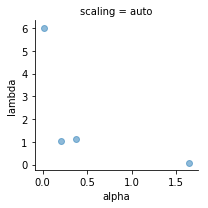

In [25]:
# it will show me on what  value of alpha or lmbda, I trained the my training jobs

g = sns.FacetGrid(df_auto, col="scaling", palette='viridis')
g = g.map(plt.scatter, "alpha", "lambda", alpha=0.5)

In [26]:
# all details regarding hypertuning job log scale
bayes_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuner_auto._current_job_name).dataframe()
bayes_metrics.sort_values(['FinalObjectiveValue'], ascending=False)

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,alpha,lambda
1,0.872899,48.0,2020-05-27 18:31:30+00:00,xgboost-200527-1824-003-3b11d3cf,Completed,2020-05-27 18:30:42+00:00,1.644504,0.087318
0,0.872374,54.0,2020-05-27 18:31:48+00:00,xgboost-200527-1824-004-fee029b4,Completed,2020-05-27 18:30:54+00:00,0.012074,6.018871
2,0.869748,66.0,2020-05-27 18:28:10+00:00,xgboost-200527-1824-002-f19b07a7,Completed,2020-05-27 18:27:04+00:00,0.378071,1.118859
3,0.860819,48.0,2020-05-27 18:28:08+00:00,xgboost-200527-1824-001-9478b454,Completed,2020-05-27 18:27:20+00:00,0.203701,1.020165


In [ ]:
# all details regarding hypertuning job linear scale

#bayes_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuner_linear._current_job_name).dataframe()
# bayes_metrics.sort_values(['FinalObjectiveValue'], ascending=False)

In [ ]:

## xgb_predictor = tuner_auto.deploy(initial_instance_count=1,instance_type='ml.t2.medium')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import time as t


      
# print(t.time()-start)

# Decision Tree
'''
start=t.time()
decision_c=DecisionTreeClassifier()
decision_c.fit(X_train,y_train)
print(decision_c.score(X_test,y_test))
print(t.time()-start)

# SVM
start=t.time()
svm_c=SVC()
svm_c.fit(X_train,y_train)
print(svm_c.score(X_test,y_test))
print(t.time()-start)

# Random Forest
start=t.time()
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)
print(rfc.score(X_test,y_test))
print(t.time()-start)

# naive bayes classier
start=t.time()
naive_bc=GaussianNB()
naive_bc.fit(X_train,y_train)
print(naive_bc.score(X_test,y_test))
print(t.time()-start)
'''

In [ ]:
# logistic regression
log_r=RandomForestClassifier(n_estimators=100)
log_r.fit(train_data.drop(['Survived'],axis=1),train_data['Survived'])
print(log_r.score(test_data.drop(['Survived'],axis=1),test_data['Survived']))